#### Matthew Powers and Parker Spaan
###### The following program is an expansion of Professor Artzis orginal data and program that he had been working on. This program is utilizing BERT transformers to better understand the queues of one word to another. This is then coupled with passing in our pretrained data that labels exactly what is happeing. For example "Im so sorry for your loss" would be trained as "sadness". the transformer knows how words are connected, and then using the data passed in to predict utsing pytorch and the facehugging transformer it will predict what a new sentance or article has for setimentation. Is the overall happy, sad, joyful, annoyed, etc.

###### Directly below we are getting in our .csv that has our data, as well as getting our transformers inplace to be able to compute. We will then fit the transformer, and then split our testing data into 80-20 and selecting our seed to be 42. We then begin working on our model from bert-base-uncased to tokenize our training data as well as get the model to begin prediciting what is happening. This model is taking in the data and with the transformer finding the connection between specific words (whether nouns, verbs adjectives, etc.) and finding what emotion they are able to convey based on the data that was provided.

In [18]:
import pandas as pd
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments


# Load the dataset
data = pd.read_csv("sentiment_dataset.csv")
X = data["sentence"]
y = data["label"]

# i = 0         This is to get each of the setiments that a sentance could be
# this = [0]
# for i in range(len(y)):
#     if i == 0 or y[i] == y[i-1]:
#         i += 1
#         continue
#     if i == len(y) - 1 :
#         break
#     else:
#         this.append(y[i])
# print(this)


# Encode the labels as integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Specify the pre-trained model you want to use
model_name = "bert-base-uncased"

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenize the data
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True)
val_encodings = tokenizer(X_val.tolist(), truncation=True, padding=True)

# Create a custom dataset class
class SentimentDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

[0, 'amusement', 'Anger', 'anger', 'Anger', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'Disgust', 'disgust', 'embarrassment', 'excitement', 'Fear', 'fear', 'Fear', 'fear', 'gratitude', 'grief', 'Happiness', 'joy', 'label', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'Sadness', 'sadness', 'Sadness', 'sadness', 'Surprise', 'surprise', 'Surprise', 'surprise']


###### Here we are using our transformer and trainig the model. With the model in place we are able to train it with the data from our .csv. The model understands the relationship betweens tokens and from this it then constucts its predicitons based on what the data provided. Exmaple: that house is beutiful.  Having a noun folowed by an adjective. It is able to predict with the adectuve that is positive that it is admiration.
###### We are now going to save our fine tuned BERT model to a directory "fine_tuned_model" So it can later be accessed in order to test other statements against. Need to have it saved so articles and other word structurtes can be loaded intop the transformer that was created/ fine tuned.

In [9]:
# Create dataset objects
train_dataset = SentimentDataset(train_encodings, y_train.tolist())
val_dataset = SentimentDataset(val_encodings, y_val.tolist())

# Load the pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(set(y)))

# Set up training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="steps",
    eval_steps=100,
)

# Create a Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)
# # Train the model
trainer.train()
# Save the fine-tuned model
save_directory = "./fine_tuned_model"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

###### This is first grabbing our saved fine tuned model. It is then tokenizing our passed in string to then be passed to our trained model. Once this is done it will then be able to predict the emotion that is being conveyed through the text. This is mainly strings being tokenized and then being pushed throguh a model with graients not being included in order to speed up the process. It will then print out what it believes the label should be based on its training.

In [10]:
import gc
import torch

# Delete the model and input tensors
del model

# Explicitly call the garbage collector
gc.collect()

# Clear GPU cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

print("GPU memory cleared.")

GPU memory cleared.


###### Here we are testing our model to see what the accuracy of the model is. This will use the saved model from above. It will then split and train as above. This will not pass in the 20% that is for testing. It will run the model against these testing data and when completed it will then be able to look at what the actual classification of the data was meant to be. From here it will show the accuracy of the model as it has how many it got correct vs incorrect. This model holds a 78% acccuracy based on the training and testing data provided.

In [11]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
torch.cuda.empty_cache()
def batch(iterable, batch_size=1):
    length = len(iterable)
    for index in range(0, length, batch_size):
        yield iterable[index:min(index + batch_size, length)]

# Load the dataset
data = pd.read_csv("sentiment_dataset.csv")
X = data["sentence"]
y = data["label"]

# Encode the labels as integers
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load the fine-tuned model and tokenizer
save_directory = "./fine_tuned_model"
tokenizer = AutoTokenizer.from_pretrained(save_directory)
model = AutoModelForSequenceClassification.from_pretrained(save_directory)

# Move the model to the device
model.to(device)

# Process the validation set in batches of 16
if torch.cuda.is_available():
    torch.cuda.empty_cache()
batch_size = 16
predicted_labels = []

for batch_sentences in batch(X_val, batch_size):
    # Tokenize the sentences
    batch_inputs = tokenizer(batch_sentences.tolist(), truncation=True, padding=True, return_tensors="pt")

    # Move input tensors to the device
    batch_inputs = {key: tensor.to(device) for key, tensor in batch_inputs.items()}

    # Get the model's output for the sentences
    with torch.no_grad():
        batch_outputs = model(**batch_inputs)

    # Get the predicted label indices
    batch_predicted_indices = torch.argmax(batch_outputs.logits, dim=-1).cpu().numpy()

    # Convert the predicted label indices back to the original labels
    batch_predicted_labels = label_encoder.inverse_transform(batch_predicted_indices)
    predicted_labels.extend(batch_predicted_labels)
    torch.cuda.empty_cache()
    
# Calculate the accuracy
y_val_original = label_encoder.inverse_transform(y_val)
accuracy = np.mean(predicted_labels == y_val_original)
print(f"Accuracy: {accuracy * 100:.2f}%")


Using device: cuda


C:\Users\12487\AppData\Local\Temp\ipykernel_26648\129072765.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield iterable[index:min(index + batch_size, length)]


Accuracy: 78.74%


#### Confusion Matrix
###### Below is the created Confusion Matrix for our model. This will takein our orginal and predicted values, and plot the matrix of the two models together. This is for the reader to understand/ see what emotions are sometimes classsified incorrecctly as another emotion based on the setiment of the language tjat was picked up on. As shown at times admiration and joy are sometimes classified as the same emotion. This is expected as humans are unaware of how to compute those two emotions at times as well. The below is mainly for readers to better understand what is happening within our model and where emotions may be incorrectly classified.

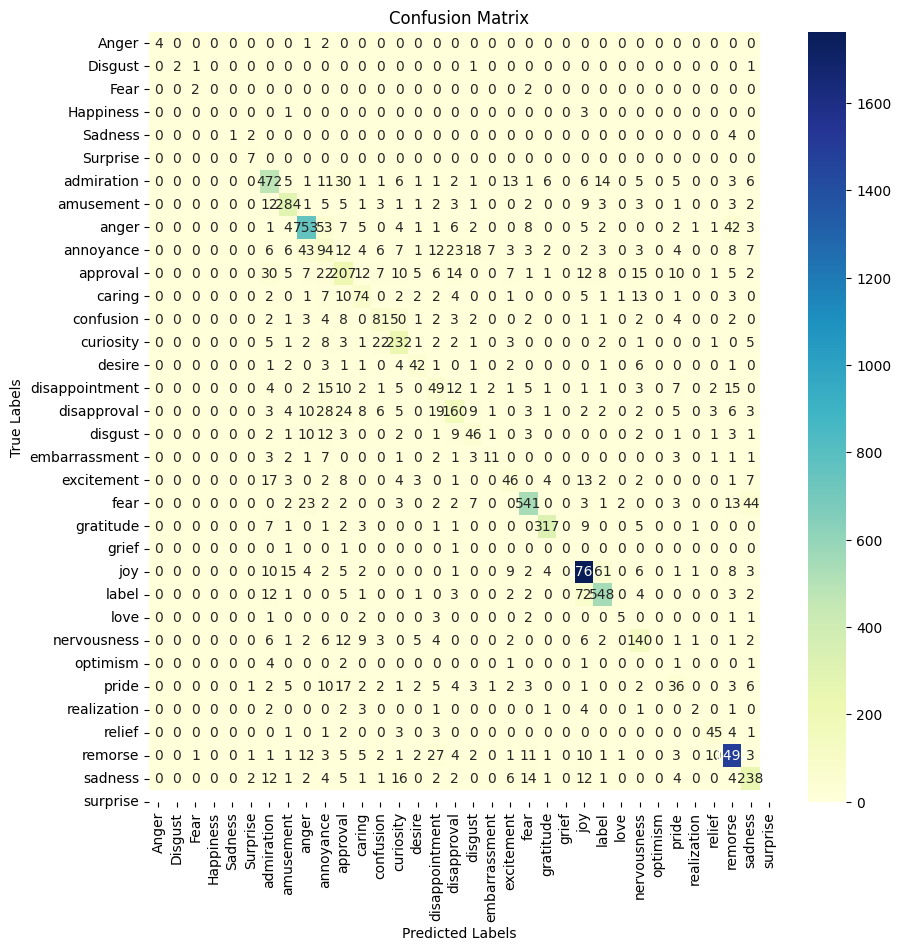

In [12]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you already have predicted_labels and y_val_original from the previous code

# Calculate the confusion matrix
cm = confusion_matrix(y_val_original, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()


#### Conclusions


In conclusion, the development of a transformer model with a 78.74% accuracy in sentiment analysis, using bert-base-uncased as a base model, represents a significant achievement in the field of natural language processing. The model showcases the power and flexibility of pre-trained architectures like BERT, which can be fine-tuned to perform specific tasks such as sentiment analysis with relatively high precision. While the accuracy achieved is not perfect, it demonstrates the model's ability to understand and process complex linguistic patterns within textual data.

Moving forward, there is still room for improvement in the model's performance by exploring novel techniques and optimizations, such as better pre-processing of the input data, more efficient fine-tuning strategies, or incorporating additional layers to the architecture. Furthermore, investigating the model's shortcomings on specific types of sentiment or within certain domains can provide valuable insights to guide future research.

Overall, this transformer model represents an important step in the ongoing quest to develop more advanced and accurate natural language processing tools. As these models continue to evolve, they will play a pivotal role in enabling applications that can understand and interpret human emotions, leading to improved user experiences and more intelligent systems across various industries.